In [ ]:
pip install scipy


In [ ]:
pip install scikit-plot

In [192]:
pip install dython

  Using cached dython-0.7.0-py3-none-any.whl (20 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dython import nominal

In [1]:
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException
from selenium import webdriver
import time
import pandas as pd
from selenium.webdriver.common.action_chains import ActionChains
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [48]:
import glassdoor_scraper as gs 
import pandas as pd 

df = gs.get_jobs('data engineer', 600, False)

df.to_csv('glassdoor_engineer_jobs.csv', index = False)

Progress: 0/600
Progress: 1/600
Progress: 2/600
Progress: 3/600
Progress: 4/600
Progress: 5/600
Progress: 6/600
Progress: 7/600
Progress: 8/600
Progress: 9/600
Progress: 10/600
Progress: 11/600
Progress: 12/600
Progress: 13/600
Progress: 14/600
Progress: 15/600
Progress: 16/600
Progress: 17/600
Progress: 18/600
Progress: 19/600
Progress: 20/600
Progress: 21/600
Progress: 22/600
Progress: 23/600
Progress: 24/600
Progress: 25/600
Progress: 26/600
Progress: 27/600
Progress: 28/600
Progress: 29/600
Progress: 30/600
Progress: 31/600
Progress: 32/600
Progress: 33/600
Progress: 34/600
Progress: 35/600
Progress: 36/600
Progress: 37/600
Progress: 38/600
Progress: 39/600
Progress: 40/600
Progress: 41/600
Progress: 42/600
Progress: 43/600
Progress: 44/600
Progress: 45/600
Progress: 46/600
Progress: 47/600
Progress: 48/600
Progress: 49/600
Progress: 50/600
Progress: 51/600
Progress: 52/600
Progress: 53/600
Progress: 54/600
Progress: 55/600
Progress: 56/600
Progress: 57/600
Progress: 58/600
Progres

Merging data, removing duplicates, removing unwanted columns

In [3]:
df_engineer = pd.read_csv('engineer_jobs-450.csv', index_col = 0)
df_analyst = pd.read_csv('glassdoor_analyst_jobs.csv')
df_scientist = pd.read_csv('glassdoor_jobs.csv', index_col=0)
df_scientist_300 = pd.read_csv('jobs-300.csv', index_col=0)
df_scientist_400 = pd.read_csv('jobs-400.csv', index_col=0)

In [4]:
df_jobs_new = pd.concat([df_scientist_300, df_scientist_400, df_analyst, df_engineer], ignore_index=True)

In [5]:
df_jobs_new = df_jobs_new.drop_duplicates()

In [6]:
df_scientist = df_scientist.drop(columns = ['Rating', 'Headquarters', 'Competitors'])

In [7]:
df_master = pd.concat([df_scientist, df_jobs_new], ignore_index=True)

In [8]:
df_master = df_master.drop_duplicates()

# Data Cleansing

1. Salaries

In [9]:
df_master = df_master[df_master['Salary Estimate'] != '-1']
df_master = df_master.reset_index()

In [10]:
df_master['hourly'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'per hour' in x.lower() else 0)
df_master['employer_provided'] = df_master['Salary Estimate'].apply(lambda x: 1 if 'employer provided salary' in x.lower() else 0)

In [11]:
salary = df_master['Salary Estimate'].apply(lambda x: x.split('(')[0])
without_Kd = salary.apply(lambda x: x.replace('K', '').replace('$', ''))
pure_salary = without_Kd.apply(lambda x: x.lower().replace('employer provided salary:', '').replace('per hour', '').replace(' ', ''))

In [12]:
df_master['Min Salary'] = pure_salary.apply(lambda x: int(x.split('-')[0]))
df_master['Max Salary'] = pure_salary.apply(lambda x: int(x.split('-')[1]) if len(x) > 3 else int(x.split('-')[0]))

In [13]:
df_master['Average Salary'] = (df_master['Max Salary'] + df_master['Min Salary']) / 2

2. Extract ratings from Company names

In [14]:
rating = df_master['Company Name'].apply(lambda x : x[-3:] if x is not np.nan else x)

In [15]:
# function that return True if there are any numbers in string and returns False if number is abscent

def num_there(s):
    return any(i.isdigit() for i in s)

In [16]:
rating = rating.apply(lambda x : x if x is not np.nan and num_there(x) else '-1' )

In [17]:
df_master['Rating'] = rating

In [18]:
df_master['company_text'] = df_master.apply(lambda x: x['Company Name'] if float(x['Rating']) < 0 else x['Company Name'][:-3], axis = 1)
df_master['company_text'] = df_master['company_text'].apply(lambda x : x.replace('\n', '') if x is not np.nan else x)

3. Location. Split city and state into different columns

In [19]:
df_master['Location'] = df_master['Location'].apply(lambda x : x.replace('Remote', 'Remote, Remote'))

In [20]:
df_master['city'] = df_master['Location'].apply(lambda x : x.split(',')[0])
df_master['state'] = df_master['Location'].apply(lambda x : x.split(',')[1])
df_master['state'] = df_master['state'].apply(lambda x : x.replace(' ', ''))

In [45]:
df_master['state'] = df_master['state'].apply(lambda x : x.replace('LosAngeles', 'CA') if x =='LosAngeles' else x)

In [46]:
df_master['state'].value_counts()

CA        181
NY        100
MA         73
VA         35
Remote     32
WA         32
MD         29
TX         28
IL         27
PA         22
DC         19
FL         15
NJ         15
UT         13
NC         13
CO         12
MO         10
TN          9
OH          9
IN          8
OR          8
WI          7
AZ          7
AL          6
GA          6
CT          6
NE          5
KY          5
MI          4
OK          4
IA          3
LA          3
ID          3
SC          2
NM          2
DE          2
MN          2
RI          1
KS          1
AR          1
AS          1
Name: state, dtype: int64

4. Column "Founded" change to company age

In [22]:
df_master['company_age'] = df_master['Founded'].apply(lambda x: (2022 - x) if x > 0 else x)

5. Get some information from description

In [23]:
# Python
df_master['python'] = df_master['Job Description'].apply(lambda x : 1 if 'python' in x.lower() else 0)
df_master['python'].value_counts()

1    466
0    295
Name: python, dtype: int64

In [24]:
# R Studio. There is way more than that. But because it is beeing used as 'R' in most description we can not get it. It will find all lerrer R.
df_master['r_studio'] = df_master['Job Description'].apply(lambda x : 1 if 'r studio' in x.lower() or 'r-studio' in x.lower() else 0)
df_master['r_studio'].value_counts()

0    755
1      6
Name: r_studio, dtype: int64

In [25]:
# SQL
df_master['sql'] = df_master['Job Description'].apply(lambda x : 1 if 'sql' in x.lower() else 0)
df_master['sql'].value_counts()

1    457
0    304
Name: sql, dtype: int64

In [26]:
# Javascript
df_master['javascript'] = df_master['Job Description'].apply(lambda x : 1 if 'javascript' in x.lower() else 0)
df_master['javascript'].value_counts()

0    727
1     34
Name: javascript, dtype: int64

In [27]:
# Spark
df_master['spark'] = df_master['Job Description'].apply(lambda x : 1 if 'spark' in x.lower() else 0)
df_master['spark'].value_counts()

0    599
1    162
Name: spark, dtype: int64

In [28]:
# Excel
df_master['excel'] = df_master['Job Description'].apply(lambda x : 1 if 'excel' in x.lower() else 0)
df_master['excel'].value_counts()

1    396
0    365
Name: excel, dtype: int64

In [29]:
# hadoop
df_master['hadoop'] = df_master['Job Description'].apply(lambda x : 1 if 'hadoop' in x.lower() else 0)
df_master['hadoop'].value_counts()

0    650
1    111
Name: hadoop, dtype: int64

In [30]:
# aws
df_master['aws'] = df_master['Job Description'].apply(lambda x : 1 if 'aws' in x.lower() else 0)
df_master['aws'].value_counts()

0    569
1    192
Name: aws, dtype: int64

In [31]:
# scala
df_master['scala'] = df_master['Job Description'].apply(lambda x : 1 if 'scala' in x.lower() else 0)
df_master['scala'].value_counts()

0    593
1    168
Name: scala, dtype: int64

In [32]:
# power bi
df_master['power_bi'] = df_master['Job Description'].apply(lambda x : 1 if 'power bi' in x.lower() else 0)
df_master['power_bi'].value_counts()

0    718
1     43
Name: power_bi, dtype: int64

In [33]:
# tableau
df_master['tableau'] = df_master['Job Description'].apply(lambda x : 1 if 'tableau' in x.lower() else 0)
df_master['tableau'].value_counts()

0    586
1    175
Name: tableau, dtype: int64

In [58]:
# machine learning
df_master['mle'] = df_master['Job Description'].apply(lambda x : 1 if 'machine learning' in x.lower() else 0)
df_master['mle'].value_counts()

0    457
1    304
Name: mle, dtype: int64

6. Get seniority

In [94]:
def seniority(title):
    if 'senior' in title.lower() or 'sr' in title.lower() or 'sr.' in title.lower() or 'lead' in title.lower() or 'chief' in title.lower() or 'principal' in title.lower() or 'director' in title.lower():
        return 'senior'
    elif 'jr.' in title.lower() or 'jr' in title.lower() or 'junior' in title.lower():
        return 'junior'
    else:
        return 'na'

In [95]:
df_master['seniority'] = df_master['Job Title'].apply(seniority)
df_master['seniority'].value_counts()

na        598
senior    139
junior     24
Name: seniority, dtype: int64

7. Normalise Job Titles

In [96]:
def title_norm(title):
    if 'data analyst' in title.lower() or 'analyst' in title.lower():
        return 'data analyst'
    elif 'scientist' in title.lower() or 'science' in title.lower() or 'data scientist' in title.lower():
        return 'data scientist'
    elif 'engineer' in title.lower():
        return 'data engineer'
    elif 'manager' in title.lower():
        return 'manager'
    else:
        return 'na'

In [97]:
df_master['job_title_norm'] = df_master['Job Title'].apply(title_norm)
df_master['job_title_norm'].value_counts()

data scientist    392
data engineer     176
data analyst      166
na                 20
manager             7
Name: job_title_norm, dtype: int64

In [47]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'Min Salary', 'Max Salary', 'Average Salary', 'Rating', 'company_text',
       'city', 'state', 'company_age', 'python', 'r_studio', 'sql',
       'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi',
       'tableau', 'seniority', 'job_title_norm'],
      dtype='object')

8. Change hourly to yearly salary

In [50]:
df_master['Min Salary'] = df_master.apply(lambda x: x['Min Salary'] * 2 if x.hourly == 1 else x['Min Salary'], axis = 1)

In [51]:
df_master['Max Salary'] = df_master.apply(lambda x: x['Max Salary'] * 2 if x.hourly == 1 else x['Max Salary'], axis = 1)

In [52]:
df_master['Average Salary'] = df_master.apply(lambda x: x['Average Salary'] * 2 if x.hourly == 1 else x['Average Salary'], axis = 1)

9. Get the description length. Remove all "\n" in the text.

In [53]:
df_master['Job Description'][1]

'What You Will Do:\n\nI. General Summary\n\nThe Healthcare Data Scientist position will join our Advanced Analytics group at the University of Maryland Medical System (UMMS) in support of its strategic priority to become a data-driven and outcomes-oriented organization. The successful candidate will have 3+ years of experience with Machine Learning, Predictive Modeling, Statistical Analysis, Mathematical Optimization, Algorithm Development and a passion for working with healthcare data. Previous experience with various computational approaches along with an ability to demonstrate a portfolio of relevant prior projects is essential. This position will report to the UMMS Vice President for Enterprise Data and Analytics (ED&A).\n\nII. Principal Responsibilities and Tasks\n\n• Develops predictive and prescriptive analytic models in support of the organization’s clinical, operations and business initiatives and priorities.\n• Deploys solutions so that they provide actionable insights to the

In [54]:
df_master['Job Description'] = df_master['Job Description'].apply(lambda x : x.replace('\n\n', ' '))

In [55]:
df_master['Job Description'][1]

'What You Will Do: I. General Summary The Healthcare Data Scientist position will join our Advanced Analytics group at the University of Maryland Medical System (UMMS) in support of its strategic priority to become a data-driven and outcomes-oriented organization. The successful candidate will have 3+ years of experience with Machine Learning, Predictive Modeling, Statistical Analysis, Mathematical Optimization, Algorithm Development and a passion for working with healthcare data. Previous experience with various computational approaches along with an ability to demonstrate a portfolio of relevant prior projects is essential. This position will report to the UMMS Vice President for Enterprise Data and Analytics (ED&A). II. Principal Responsibilities and Tasks • Develops predictive and prescriptive analytic models in support of the organization’s clinical, operations and business initiatives and priorities.\n• Deploys solutions so that they provide actionable insights to the organizatio

In [56]:
df_master['Job Description'] = df_master['Job Description'].apply(lambda x : x.replace('\n', ''))

In [62]:
df_master['Job Description'][1]

'What You Will Do: I. General Summary The Healthcare Data Scientist position will join our Advanced Analytics group at the University of Maryland Medical System (UMMS) in support of its strategic priority to become a data-driven and outcomes-oriented organization. The successful candidate will have 3+ years of experience with Machine Learning, Predictive Modeling, Statistical Analysis, Mathematical Optimization, Algorithm Development and a passion for working with healthcare data. Previous experience with various computational approaches along with an ability to demonstrate a portfolio of relevant prior projects is essential. This position will report to the UMMS Vice President for Enterprise Data and Analytics (ED&A). II. Principal Responsibilities and Tasks • Develops predictive and prescriptive analytic models in support of the organization’s clinical, operations and business initiatives and priorities.• Deploys solutions so that they provide actionable insights to the organization 

In [63]:
df_master['description_length'] = df_master["Job Description"].apply(lambda x : len(x))

In [64]:
df_master['description_length']

0      2519
1      4748
2      3431
3      3856
4      2708
       ... 
756     975
757    1175
758    4073
759    4131
760    3766
Name: description_length, Length: 761, dtype: int64

 # EDA

1. histograms
2. correlations (categorical data vs categorical data then use chi square, cramers v. If categorcial vs continiuous then point biserial correlation or correlation ratio)
2. box plots
3. categorical data, pivot tables with avg_salary
4. word cloud

In [ ]:
# Histograms of continuous data: Founded, Rating, Company age, job desciprion length, average salary

In [80]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'Min Salary', 'Max Salary', 'Average Salary', 'Rating', 'company_text',
       'city', 'state', 'company_age', 'python', 'r_studio', 'sql',
       'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi',
       'tableau', 'seniority', 'job_title_norm', 'mle', 'description_length'],
      dtype='object')

In [89]:
# %matplotlib inline 
# plt.subplot(2,2,1)
# plt.hist(df_master['Rating'], bins = 'auto')
# plt.subplot(2,2,2)
# plt.hist(df_master['company_age'], bins = 'auto')
# plt.subplot(2,2,3)
# plt.hist(df_master['description_length'], bins = 'auto')
# plt.subplot(2,2,4)
# plt.hist(df_master['Average Salary'], bins = 'auto')
# plt.show()

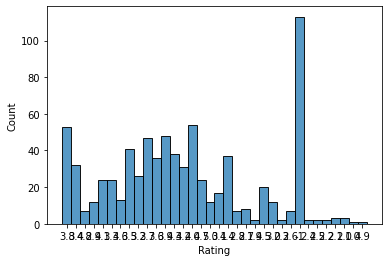

In [75]:
ax = sns.histplot(data = df_master, x = 'Rating')

Doesnt look like a normal distribution. Google what kind of distribution is that and can we fix it?

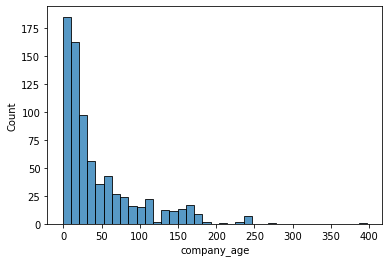

In [76]:
ax = sns.histplot(data = df_master, x = 'company_age')

In [111]:
fitted_data, fitted_lambda = stats.boxcox(df_master[df_master['company_age'] >0]['company_age'])

C:\Users\vytau\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\vytau\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

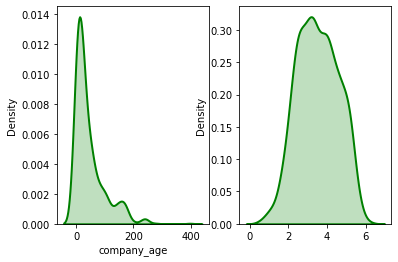

In [114]:
fig, ax = plt.subplots(1, 2)
sns.distplot(df_master['company_age'], hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Non-Normal", color ="green", ax = ax[0])
sns.distplot(fitted_data, hist = False, kde = True,
            kde_kws = {'shade': True, 'linewidth': 2}, 
            label = "Normal", color ="green", ax = ax[1])

We have an exponencial distribution. Before making the model, we should normalise it.

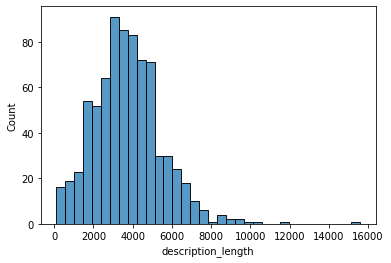

In [77]:
ax = sns.histplot(data = df_master, x = 'description_length')

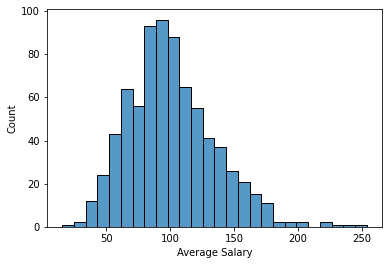

In [84]:
ax = sns.histplot(data = df_master, x = 'Average Salary')

2. Box plots. Find if we have many outliers

<AxesSubplot:>

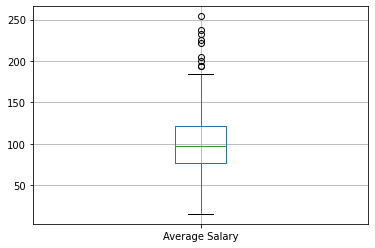

In [102]:
df_master.boxplot(column='Average Salary')

<AxesSubplot:>

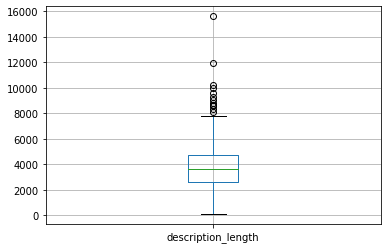

In [103]:
df_master.boxplot(column='description_length')

<AxesSubplot:>

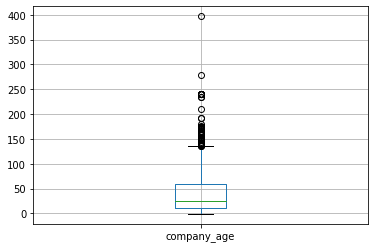

In [104]:
df_master.boxplot(column='company_age')

In [93]:
df_master[df_master['Average Salary'] > 190]

,index,Job Title,Salary Estimate,Job Description,Company Name,Location,Size,Founded,Type of ownership,Industry,...,excel,hadoop,aws,scala,power_bi,tableau,seniority,job_title_norm,mle,description_length
97,117,Senior Data Scientist,$200K-$275K(Employer est.),Who we want:Are you committed to using your ta...,Gallup\n4.2,"Washington, DC",1001 to 5000 employees,1935,Company - Private,Consulting,...,1,0,0,0,0,0,senior,data scientist,1,3282
164,208,Principal Data Scientist with over 10 years ex...,Employer Provided Salary:$200K-$250K,Position Title: Principal Data ScientistLocati...,CA-One Tech Cloud,"San Francisco, CA",51 to 200 employees,2017,Company - Private,IT Services,...,1,0,1,0,0,1,na,data scientist,1,1608
183,235,Lead Data Engineer,$190K-$220K(Employer est.),Credit Sesame is bringing cash and credit toge...,Credit Sesame\n4.1,"Mountain View, CA",51 to 200 employees,2010,Company - Private,Internet,...,0,0,1,0,0,0,senior,data engineer,1,4004
280,452,"Director II, Data Science - GRM Actuarial",$202K-$306K (Glassdoor est.),Advance your career at Liberty Mutual Insuranc...,Liberty Mutual Insurance\n3.3,"Chicago, IL",10000+ employees,1912,Company - Private,Insurance Carriers,...,0,0,0,0,0,0,na,data scientist,0,4446
329,524,"Director II, Data Science - GRS Predictive Ana...",$150K-$239K (Glassdoor est.),Advance your career at Liberty Mutual Insuranc...,Liberty Mutual Insurance\n3.3,"Chicago, IL",10000+ employees,1912,Company - Private,Insurance Carriers,...,0,0,0,0,0,0,na,data scientist,0,3907
343,548,Principal Machine Learning Scientist,$176K-$289K (Glassdoor est.),"Today, nearly every business in the world has ...",Sage Intacct\n4.7,"San Francisco, CA",501 to 1000 employees,1999,Subsidiary or Business Segment,Computer Hardware & Software,...,0,0,0,0,0,0,na,data scientist,1,3826
386,648,Principal Data Scientist,$150K-$238K (Glassdoor est.),Position Overview The Climate Corporation is l...,The Climate Corporation\n3.2,"San Francisco, CA",501 to 1000 employees,2006,Subsidiary or Business Segment,Enterprise Software & Network Solutions,...,1,0,1,1,0,0,na,data scientist,1,4809
432,782,Data Science Manager,$171K-$272K (Glassdoor est.),About us:Grand Rounds is a new kind of healthc...,Grand Rounds\n4.2,"San Francisco, CA",501 to 1000 employees,2011,Company - Private,Health Care Services & Hospitals,...,1,0,0,0,0,0,na,data scientist,1,4911
686,1192,Data Center Engineer - Cisco ACI,Employer Provided Salary:$150K - $250K,Join a team of highly motivated and talented E...,Enodo Networks,"Lanham, MD",-1,-1,NaN,-1,...,0,0,0,0,0,0,na,data engineer,0,1720


3. Categorical data EDA

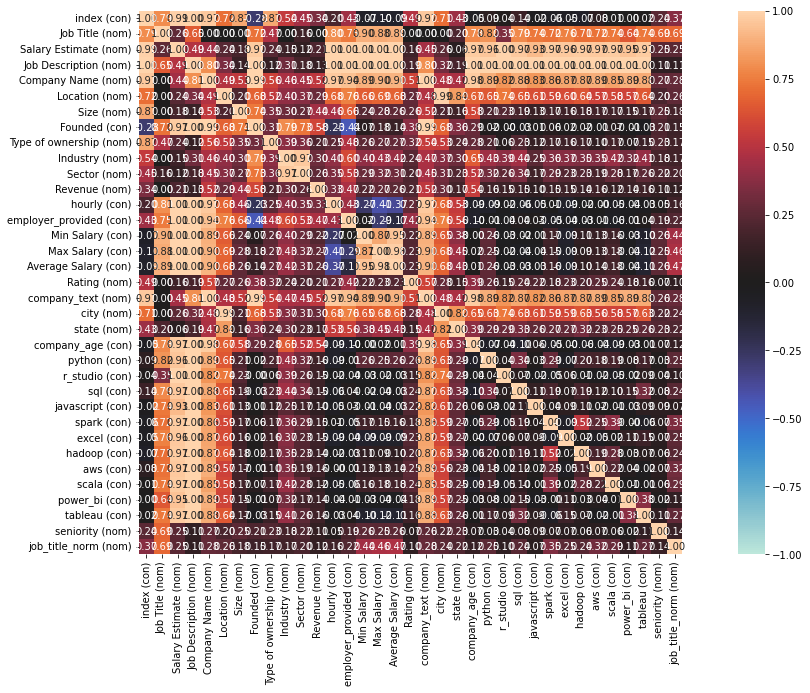

In [38]:
nominal.associations(df_master,figsize=(20,10),mark_columns=True);

In [170]:
df_master.columns

Index(['index', 'Job Title', 'Salary Estimate', 'Job Description',
       'Company Name', 'Location', 'Size', 'Founded', 'Type of ownership',
       'Industry', 'Sector', 'Revenue', 'hourly', 'employer_provided',
       'Min Salary', 'Max Salary', 'Average Salary', 'Rating', 'company_text',
       'city', 'state', 'company_age', 'python', 'r_studio', 'sql',
       'javascript', 'spark', 'excel', 'hadoop', 'aws', 'scala', 'power_bi',
       'tableau', 'seniority', 'job_title_norm'],
      dtype='object')

[Text(0, 0, 'NM'),
 Text(1, 0, 'MD'),
 Text(2, 0, 'FL'),
 Text(3, 0, 'WA'),
 Text(4, 0, 'NY'),
 Text(5, 0, 'TX'),
 Text(6, 0, 'CA'),
 Text(7, 0, 'VA'),
 Text(8, 0, 'MA'),
 Text(9, 0, 'NJ'),
 Text(10, 0, 'CO'),
 Text(11, 0, 'IL'),
 Text(12, 0, 'KY'),
 Text(13, 0, 'OR'),
 Text(14, 0, 'CT'),
 Text(15, 0, 'MI'),
 Text(16, 0, 'DC'),
 Text(17, 0, 'OH'),
 Text(18, 0, 'AL'),
 Text(19, 0, 'MO'),
 Text(20, 0, 'PA'),
 Text(21, 0, 'GA'),
 Text(22, 0, 'IN'),
 Text(23, 0, 'LA'),
 Text(24, 0, 'WI'),
 Text(25, 0, 'NC'),
 Text(26, 0, 'AZ'),
 Text(27, 0, 'NE'),
 Text(28, 0, 'MN'),
 Text(29, 0, 'UT'),
 Text(30, 0, 'TN'),
 Text(31, 0, 'DE'),
 Text(32, 0, 'ID'),
 Text(33, 0, 'RI'),
 Text(34, 0, 'IA'),
 Text(35, 0, 'SC'),
 Text(36, 0, 'KS'),
 Text(37, 0, 'OK'),
 Text(38, 0, 'Remote'),
 Text(39, 0, 'AR'),
 Text(40, 0, 'AS')]

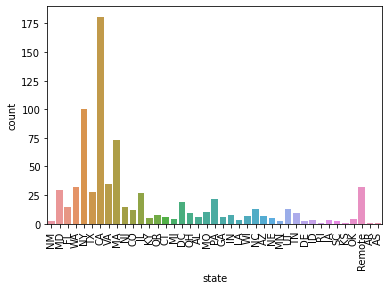

In [182]:
ax = sns.countplot(data = df_master, x='state')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [185]:
df_master[['company_age', 'Average Salary', 'Rating']].corr()

,company_age,Average Salary
company_age,1.000000,0.011814
Average Salary,0.011814,1.000000
